In [2]:
import requests as r
import pandas as pd
from matplotlib import pyplot as plt
from bs4 import BeautifulSoup as bs
%matplotlib inline
from collections import Counter
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import jieba
import json
import statistics

In [11]:
urls_list=[]

for page in range(1,60):    
    URL = "https://www.wetalk.tw/forum.php?mod=forumdisplay&fid=2&page={}"    
    resp = r.get(URL.format(page))
    
    soup = bs(resp.text, "html5lib")
    for url in range(2,len(soup.select('tbody > tr > th > a.xst'))):
        urls = soup.select('tbody > tr > th > a.xst')[url]['href']
        urls_list.append(urls)
urls_list
# with open("./urls_list.txt",'w') as f:
#     f.write(json.dumps(urls_list))

In [ ]:
cont_comm = []
for x in range(0,len(urls_list)):
    resp_c = r.get(urls_list[x])
    soup_c = bs(resp_c.text, 'html5lib')   
    
    news = {}
    news["title"]    = soup_c.select("h1.ts")[0].text.replace('\n','').strip()
    news["datetime"] = (soup_c.select('span.date-show-info')[0].text.replace('\n','').replace('發表','').strip())[:9]
    news["reply"]= soup_c.select("span.xg1 > span.xi1")[1].text.replace('\n','')
    news["content"]  = soup_c.select("td.t_f > article")[0].text.replace('\n','').replace('發表','').replace('文字轉載自 新公民議會','').replace('上傳下載附件','').replace('姬小編※※ 如果發現您的留言太長，不妨考慮投稿新公民議會，如獲刊登將有稿費喔!','').replace('圖片來源','').replace('胡嚴編輯','').replace('胡嚴','').replace('作者','').strip()

    cont_comm.append(news)    
cont_comm     
# with open("./forum.json", 'w')as f:
#     f.write(json.dumps(cont_comm))

In [7]:
data = pd.DataFrame(cont_comm)

In [ ]:
data.head()

In [ ]:
data.shape

In [61]:
stopwords = [line.replace("\n",'') for line in open('stopwords.txt','r').readlines()]

In [85]:
def stopwords(w):
    if w not in stop_tokens:
        return w

In [86]:
def regular(w):
    line = re.findall('[\u4e00-\u9fa5]+', w)
    if len(line) > 0:
        return line

In [87]:
syn_dict = {}
with open("syn.txt","r") as f :
    for line in f:
        for word in line.strip("\n").split("\t")[1:]:
            syn_dict[word] = line.strip("\n").split("\t")[0]

In [88]:
def syn(w):
    if w in syn_dict.keys():
        w=syn_dict[w]
        return w
    else:
        return w

In [89]:
#version3 cut first, not what i want
def trimming(data):
    filtered_w = []
    words = cutting(data) 
    for word in words:
        word = regular(word)
        if word is not None:
            stop_w = stopwords(word[0])
            if stop_w is not None:
                syn_w = syn(stop_w)
                filtered_w.append(syn_w)
    return " ".join(filtered_w)

In [ ]:
data["tokens"] = data['content'].map(trimming)
data["tokens"]

In [120]:
vectorizer = TfidfVectorizer(min_df=10, max_features = 10000, ngram_range=(1,2))
vz = vectorizer.fit_transform(list(data['tokens']))
key_ws = vectorizer.get_feature_names()   

In [ ]:
vectorizer = TfidfVectorizer(min_df=10, max_features = 10000, ngram_range=(1,2))
vz = vectorizer.fit_transform(list(data['tokens']))
key_ws = vectorizer.get_feature_names()   
print(vz.toarray())  

In [99]:
vz.shape

(1560, 4730)

In [ ]:
pd.DataFrame(vz.toarray())

In [101]:
tfidf = dict(zip(vectorizer.get_feature_names(),vectorizer.idf_)) 
tfidf = pd.DataFrame(columns =['tfidf']).from_dict(dict(tfidf),orient ="index") 
tfidf.columns = ['tfidf']

In [ ]:
tfidf.sort_values(by = ['tfidf'], ascending = False).head(5)

In [ ]:
tfidf.keys

In [179]:
data['datetime'] = pd.to_datetime(data['datetime'])

In [182]:
data['reply'] = pd.to_numeric(data['reply'])

In [ ]:
data.dtypes

In [192]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components = 50, random_state = 0)
svd_tfidf = svd.fit_transform(vz)
# dimenstional reduction to 50

In [ ]:
svd_tfidf.shape

In [ ]:
svd_tfidf

In [ ]:
pd.DataFrame(svd_tfidf)

In [205]:
from sklearn.manifold import TSNE
tsne_model = TSNE(n_components = 2, verbose = 1, random_state = 0)
tsne_tfidf = tsne_model.fit_transform(svd_tfidf)
# dimenstional reduction to 2

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1560 samples in 0.003s...
[t-SNE] Computed neighbors for 1560 samples in 0.306s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1560
[t-SNE] Computed conditional probabilities for sample 1560 / 1560
[t-SNE] Mean sigma: 0.132436
[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.778198
[t-SNE] Error after 1000 iterations: 1.332019


In [ ]:
tsne_tfidf.shape

In [ ]:
tsne_tfidf

In [ ]:
tfidf_df = pd.DataFrame(tsne_tfidf, columns=['x', 'y'])
tfidf_df['content'] = data['content']
tfidf_df['tokens'] = data['tokens']
tfidf_df['reply'] = data['reply']
tfidf_df.head()

In [224]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
from sklearn.cluster import MiniBatchKMeans

num_clusters = 30
kmeans_model = MiniBatchKMeans(n_clusters = num_clusters , init = 'random', max_iter = 2000, batch_size = 500, 
                               verbose = False, init_size = 1500, n_init = 1, reassignment_ratio = 0.01)
kmeans = kmeans_model.fit(vz)
kmeans_clusters = kmeans.predict(vz)
kmeans_distances = kmeans.transform(vz)

In [ ]:
pd.DataFrame(kmeans_distances)

In [232]:
kmeans_clusters

array([10, 17, 18, ..., 24, 17, 17], dtype=int32)

In [ ]:
sorted_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(num_clusters):
    print("Cluster %d:" % i)
    aux = ''
    for j in sorted_centroids[i, :15]:
        aux += terms[j] + ' | '
    print(aux)
    print()

In [252]:
tsne_kmeans = tsne_model.fit_transform(kmeans_distances)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1560 samples in 0.002s...
[t-SNE] Computed neighbors for 1560 samples in 0.305s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1560
[t-SNE] Computed conditional probabilities for sample 1560 / 1560
[t-SNE] Mean sigma: 0.029763
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.522301
[t-SNE] Error after 1000 iterations: 0.987060


In [257]:
kmeans_clusters

array([10, 17, 18, ..., 24, 17, 17], dtype=int32)

In [ ]:
cluster_group = kmeans_df.groupby("cluster")
cluster_group.size()

In [ ]:
##以下為ＬＤＡ

In [271]:
import lda
from sklearn.feature_extraction.text import CountVectorizer
import logging
logging.getLogger("lda").setLevel(logging.WARNING)


In [272]:
cvectorizer = CountVectorizer(min_df=2, max_features=10000, ngram_range=(1,2))
cvz = cvectorizer.fit_transform(data['tokens'])
n_topics = 50
n_iter = 3000
lda_model = lda.LDA(n_topics=n_topics, n_iter=n_iter)
X_topics =lda_model.fit_transform(cvz)
# Linear Discriminant Analysis (LDA)
# A classifier with a linear decision boundary, 
# generated by fitting class conditional densities to the data and using Bayes’ rule.
# The model fits a Gaussian density to each class, assuming that all classes share the same covariance matrix.
# The fitted model can also be used to reduce the dimensionality of the input, 
# by projecting it to the most discriminative directions.
# 把詞向量化決定分多少群， min_df，n_topics,n_iter的數字改變都會改變分群結果，需要改變後觀察
# min_df=1，n_topics = 20，n_iter = 2000，目前分得最好

/home/ubuntu/.pyenv/versions/3.6.1/lib/python3.6/site-packages/lda/utils.py:55: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if sparse and not np.issubdtype(doc_word.dtype, int):


In [ ]:
n_top_words = 15
topic_summaries = []
topic_word = lda_model.topic_word_  
vocab = cvectorizer.get_feature_names()
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    topic_summaries.append(''.join(topic_words))
    print("Topic{}: {}".format(i, ' '.join(topic_words)))
# "topic_word" is topic_dist(distance)

In [282]:
tsne_lda = tsne_model.fit_transform(X_topics)
# tsne_lda
# Mean sigma 標準差（大離散程度大）
# KL idvergence: KL散度（Kullback–Leibler divergence，簡稱KLD），
#               又稱相對熵（relative entropy）(entropy R教過，計算系统的论乱程度)
# 衡量的是相同事件空間裡的兩個概率分佈的差異情況

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1560 samples in 0.003s...
[t-SNE] Computed neighbors for 1560 samples in 0.357s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1560
[t-SNE] Computed conditional probabilities for sample 1560 / 1560
[t-SNE] Mean sigma: 0.146276
[t-SNE] KL divergence after 250 iterations with early exaggeration: 77.178795
[t-SNE] Error after 1000 iterations: 1.200494


In [284]:
tsne_lda

array([[ 42.747032 ,   9.358458 ],
       [-27.726416 , -22.77305  ],
       [ 13.411821 ,  15.838533 ],
       ...,
       [-31.432158 ,  -9.820467 ],
       [ 22.768703 ,  -2.9766572],
       [  2.2816758,   2.5192378]], dtype=float32)

In [285]:
# lda_model.doc_topic_
doc_topic = lda_model.doc_topic_
lda_keys = []
for i, tweet in enumerate(data['tokens']):
    lda_keys += [doc_topic[i].argmax()]
    
# y = f(t) 是一般常見的函式，代表給定一個t值，丟到f函式中會回傳一個值給y。
# y = max f(t) 代表：y 是f(t)函式所有的值中最大的output。
# y = arg max f(t) 代表：y 是f(t)函式中，會產生最大output的那個參數t。

# 假設有一個函式 f(t)，t 的可能範圍是 {0,1,2}，f(t=0) = 10 ; f(t=1) = 20 ; f(t=2) = 7，那分別對應的y如下：
# y = max f(t)  = 20
# y* = arg max f(t) = 1

In [286]:
plot_lda = bp.figure(plot_width=700, plot_height=600, title='LDA topic visualization',
                    tools='pan,wheel_zoom, box_zoom, reset, hover, previewsave',
                    x_axis_type=None, y_axis_type=None, min_border=1)

In [287]:
lda_df = pd.DataFrame(tsne_lda, columns=['x','y'])
lda_df['reply'] = data['reply']
lda_df['datetime'] = data['datetime']
lda_df['topic'] = lda_keys
lda_df['topic'] = lda_df['topic'].map(int)
lda_df['tokens'] = data['tokens']


In [ ]:
lda_group = lda_df.groupby(lda_df['topic'])
lda_group.size()

In [ ]:
l = lda_group.get_group(11)
l.iloc[pd.to_datetime(l.datetime).values.argsort()]

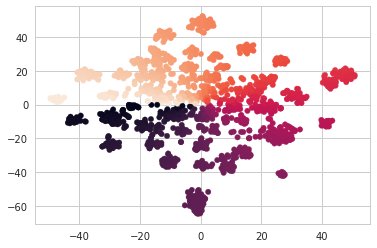

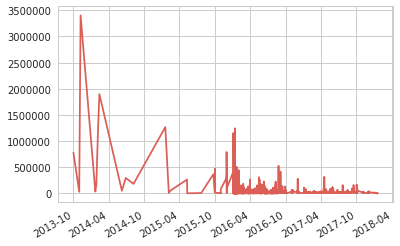

In [296]:
T = np.arctan2(Y,X)
X = lda_df['x'].tolist()
Y = lda_df['y'].tolist()
plt.scatter(X,Y, s=30, c=T, alpha=1)
plt.show()

view_list_l = lda_df['view'].tolist()
lda_df.set_index('datetime')
datetime_list_l = lda_df['datetime'].tolist()

k_plot_l = pd.Series(view_list_l, index=datetime_list_l)
k_plot_l.plot()


In [297]:
plot_lda.scatter(source=lda_df, x='x', y='y')

hover = plot_lda.select(dict(type=HoverTool))
hover.tooltips={"tokens":"@tokens", "topic":"@topic"}
show(plot_lda)

In [298]:
# lda_df['len_docs'] = data['tokens'].map(len)
lda_df['len_docs'] = data['tokens'].map(len)

In [261]:
def prepareLDAData():
    data = {
        'vocab': vocab,
        'doc_topic_dists': lda_model.doc_topic_,
        'doc_lengths': list(lda_df['len_docs']),
        'term_frequency': cvectorizer.vocabulary_,
        'topic_term_dists': lda_model.components_
    }
    return data

In [613]:
ldadata = prepareLDAData()

In [614]:
import pyLDAvis

In [615]:
pyLDAvis.enable_notebook()

In [616]:
prepared_data = pyLDAvis.prepare(**ldadata)

In [617]:
pyLDAvis.save_html(prepared_data,'./pyldavis_topic_title.html')